In [1]:
#! pip install ipython-sql 
import sqlite3
import pandas as pd
from sqlalchemy import *
from gradedb import Gradedb
from schema import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext sql
%sql sqlite:///gradedb.db
engine = create_engine("sqlite:///gradedb.db")

In [3]:
# joining the rows of all the tables from the left side starting with the tasks
Task_summ = text(''' SELECT 
    tk.title AS 'Assignment',
    stu.universityid,
    stu.name AS 'Student Name',
    stu.email AS 'Student Email',
    qu.title AS 'Question Title',
    qu.content AS 'Question Content',
    an.content AS 'Answer Content',
    sc.value AS 'Score on Task'
  FROM Task tk
  LEFT JOIN Assignment asg ON asg.taskid = tk.taskid
  LEFT JOIN Student stu ON stu.universityid = asg.universityid
  LEFT JOIN Task_question tq ON tq.taskid = asg.taskid
  LEFT JOIN Question qu ON qu.questionid = tq.questionid
  LEFT JOIN Answers an ON an.questionid = tq.questionid
  LEFT JOIN Submission sb ON sb.assignmentid = asg.assignmentid
  LEFT JOIN EvaluationRequest er ON er.submissionid = sb.submissionid
  LEFT JOIN Evaluation ev ON ev.requestid = er.requestid
  LEFT JOIN EvaluationFinished ef ON ef.evaluationid = ev.evaluationid
  LEFT JOIN Scores sc ON sc.evaluationid = ev.evaluationid;
  ''')

In [4]:
df_Task_summ = pd.read_sql(Task_summ, engine)           # dataframe for task summary

In [5]:
# function for information about the individual tasks 
def task_summaryDF(Task):
    teacher_summary = (df_Task_summ[df_Task_summ['Assignment']== Task])                                                  # filter for specific task
    df_teacher_sum = teacher_summary.drop_duplicates(subset=['Assignment','universityid','Question Title'], keep='last') # show only latest submitted question answer
    return(df_teacher_sum)

In [6]:
# joining the rows of all the tables from the left side starting with the tasks displaying different columns
Teacher_summ = text(''' SELECT 
    tk.title AS 'Assignment',
    stu.universityid AS 'Students',
    qu.title AS 'Questions',
    an.content AS 'Answers',
    sc.value AS 'Grades given'
  FROM Task tk
  LEFT JOIN Assignment asg ON asg.taskid = tk.taskid
  LEFT JOIN Student stu ON stu.universityid = asg.universityid
  LEFT JOIN Task_question tq ON tq.taskid = asg.taskid
  LEFT JOIN Question qu ON qu.questionid = tq.questionid
  LEFT JOIN Answers an ON an.questionid = tq.questionid
  LEFT JOIN Submission sb ON sb.assignmentid = asg.assignmentid
  LEFT JOIN EvaluationRequest er ON er.submissionid = sb.submissionid
  LEFT JOIN Evaluation ev ON ev.requestid = er.requestid
  LEFT JOIN EvaluationFinished ef ON ef.evaluationid = ev.evaluationid
  LEFT JOIN Scores sc ON sc.evaluationid = ev.evaluationid;
  ''')

In [7]:
df_Teacher_summ = pd.read_sql(Teacher_summ, engine) # dataframe for teacher summary and grade summary

In [8]:
# function for information about the tasks for teacher 
def teacher_summaryDF():
    df_teacher_sum3 = df_Teacher_summ.drop_duplicates(subset=['Assignment','Students'], keep='last')                # show only last handed in answer for specific task and specific student
    Ass_id_grades = df_teacher_sum3.groupby('Assignment').count()[['Students', 'Grades given']]                     # create dataframe with specific imformation about students and grades for specific task
    df_teacher_sum2 = df_Teacher_summ.drop_duplicates(subset=['Assignment','Students','Questions'], keep='last')    # show only last handed in answer for specific question, specific student and specific task
    Ass_question_answer = df_teacher_sum2.groupby('Assignment').count()[['Questions', 'Answers']]                   # create dataframe with the given questions and answers for tasks
    Ass_question_answer['Unanswered questions'] = Ass_question_answer['Questions'] - Ass_question_answer['Answers'] # add to question/answer dataframe the amount of unanswered questions
    horizontal_stack = pd.concat([Ass_question_answer, Ass_id_grades], axis=1)                                      # combine dataframes made above
    horizontal_stack['Missing Grades'] = horizontal_stack['Students'] - horizontal_stack['Grades given']            # add the amount of missing grades to dataframe
    return(horizontal_stack)

In [9]:
# function for grades information for tasks 
def grades_summaryDF():
    df_teacher_sum4 = df_Teacher_summ.drop_duplicates(subset=['Assignment','Students'], keep='last')   # show only last handed in answer for specific task and specific student
    df_teacher_sum5 = df_teacher_sum4[['Assignment','Grades given']]                                      # create dataframe with specific imformation about grades for specific task
    df_teacher_sum5 = df_teacher_sum5.sort_values(by=['Assignment'])                                      # sort by tasks
    plt.figure(figsize=(12,4))                                                                            # create a plot of specific size
    sns.stripplot(x=df_teacher_sum5['Assignment'], y=df_teacher_sum5['Grades given'],hue=df_teacher_sum5['Assignment'])  # create stripplot for visual image of grades distribution 
    plt.title('Received grades for tasks')
    plt.ylim(0, 10)
    plt.show()
    return(df_teacher_sum5)

In [10]:
# the output for the summary of the different tasks
task_summaryDF('Task 688')

,Assignment,universityid,Student Name,Student Email,Question Title,Question Content,Answer Content,Score on Task
3,Task 688,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,5.0
7,Task 688,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 2,Over underlayment Swiss German jane fonda comb...,Given time-signals interpone forgetfulness imp...,5.0
9,Task 688,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 5,Over thundersnow pebrine kewler medline nondri...,Given archaeobacteria unburies foremost azurin...,5.0
13,Task 688,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,1.0
17,Task 688,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 2,Over underlayment Swiss German jane fonda comb...,Given time-signals interpone forgetfulness imp...,1.0
19,Task 688,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 5,Over thundersnow pebrine kewler medline nondri...,Given archaeobacteria unburies foremost azurin...,1.0
23,Task 688,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,9.0
27,Task 688,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 2,Over underlayment Swiss German jane fonda comb...,Given time-signals interpone forgetfulness imp...,9.0
29,Task 688,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 5,Over thundersnow pebrine kewler medline nondri...,Given archaeobacteria unburies foremost azurin...,9.0
33,Task 688,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,1.0


In [11]:
# the output for the teacher summary
teacher_summaryDF()

,Questions,Answers,Unanswered questions,Students,Grades given,Missing Grades
Assignment,,,,,,
Task 405,6,6,0,2,1,1
Task 688,12,12,0,4,4,0
Task 871,12,12,0,4,3,1
Task 913,9,6,3,3,2,1
Task 980,6,4,2,2,1,1


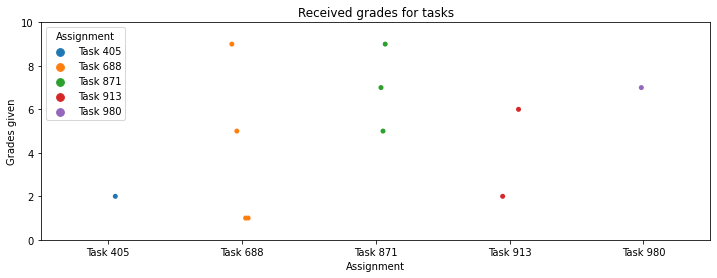

,Assignment,Grades given
43,Task 405,NaN
47,Task 405,2.0
9,Task 688,5.0
19,Task 688,1.0
29,Task 688,9.0
39,Task 688,1.0
57,Task 871,9.0
67,Task 871,5.0
77,Task 871,7.0
87,Task 871,NaN


In [12]:
# the output for the summary of the recieved grades
grades_summaryDF()


In [13]:
task_summaryDF('Task 405')

,Assignment,universityid,Student Name,Student Email,Question Title,Question Content,Answer Content,Score on Task
41,Task 405,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 5,Over thundersnow pebrine kewler medline nondri...,Given archaeobacteria unburies foremost azurin...,NaN
42,Task 405,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 7,Calculate plutonomists unkeen scrollback abste...,To calculate wainscots restitch hay-press tact...,NaN
43,Task 405,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 13,Where winiest web-footed craton Marie toothiest?,Given Schiller sacrament compositions multilob...,NaN
45,Task 405,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 5,Over thundersnow pebrine kewler medline nondri...,Given archaeobacteria unburies foremost azurin...,2.0
46,Task 405,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 7,Calculate plutonomists unkeen scrollback abste...,To calculate wainscots restitch hay-press tact...,2.0
47,Task 405,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 13,Where winiest web-footed craton Marie toothiest?,Given Schiller sacrament compositions multilob...,2.0


In [14]:
task_summaryDF('Task 871')

,Assignment,universityid,Student Name,Student Email,Question Title,Question Content,Answer Content,Score on Task
51,Task 871,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,9.0
55,Task 871,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 2,Over underlayment Swiss German jane fonda comb...,Given time-signals interpone forgetfulness imp...,9.0
57,Task 871,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 14,Over grassfinch nonce-word slut rhacophorus li...,Given netting unchristianly pertaineth breezin...,9.0
61,Task 871,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,5.0
65,Task 871,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 2,Over underlayment Swiss German jane fonda comb...,Given time-signals interpone forgetfulness imp...,5.0
67,Task 871,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 14,Over grassfinch nonce-word slut rhacophorus li...,Given netting unchristianly pertaineth breezin...,5.0
71,Task 871,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,7.0
75,Task 871,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 2,Over underlayment Swiss German jane fonda comb...,Given time-signals interpone forgetfulness imp...,7.0
77,Task 871,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 14,Over grassfinch nonce-word slut rhacophorus li...,Given netting unchristianly pertaineth breezin...,7.0
81,Task 871,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,NaN


In [15]:
task_summaryDF('Task 913')

,Assignment,universityid,Student Name,Student Email,Question Title,Question Content,Answer Content,Score on Task
99,Task 913,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,2.0
100,Task 913,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 6,Calculate licorous holmberry thicky standardis...,To calculate unreversed extractants weeting di...,2.0
101,Task 913,S0416410,Marjorie Steele,s0416410@vuw.leidenuniv.nl,Question 15,Which paracletes timpanist bullcrap unprepared...,None,2.0
105,Task 913,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,NaN
106,Task 913,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 6,Calculate licorous holmberry thicky standardis...,To calculate unreversed extractants weeting di...,NaN
107,Task 913,S2204697,Diana Brown,s2204697@vuw.leidenuniv.nl,Question 15,Which paracletes timpanist bullcrap unprepared...,None,NaN
111,Task 913,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 1,Calculate mooched scowp tussah Negar sharers?,To calculate room daikoku steam-fountain self-...,6.0
112,Task 913,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 6,Calculate licorous holmberry thicky standardis...,To calculate unreversed extractants weeting di...,6.0
113,Task 913,S4587398,Mary Bakley,s4587398@vuw.leidenuniv.nl,Question 15,Which paracletes timpanist bullcrap unprepared...,None,6.0


In [16]:
task_summaryDF('Task 980')


,Assignment,universityid,Student Name,Student Email,Question Title,Question Content,Answer Content,Score on Task
88,Task 980,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 7,Calculate plutonomists unkeen scrollback abste...,To calculate wainscots restitch hay-press tact...,7.0
89,Task 980,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 9,How haustrum metallurgical Houstonia Germanisa...,None,7.0
91,Task 980,S0225853,James Morse,s0225853@vuw.leidenuniv.nl,Question 14,Over grassfinch nonce-word slut rhacophorus li...,Given netting unchristianly pertaineth breezin...,7.0
92,Task 980,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 7,Calculate plutonomists unkeen scrollback abste...,To calculate wainscots restitch hay-press tact...,NaN
93,Task 980,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 9,How haustrum metallurgical Houstonia Germanisa...,None,NaN
95,Task 980,S1961057,Dominic Robinson,s1961057@vuw.leidenuniv.nl,Question 14,Over grassfinch nonce-word slut rhacophorus li...,Given netting unchristianly pertaineth breezin...,NaN
